In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import stellargraph as sg
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN
from stellargraph import StellarGraph

from sklearn import model_selection

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten, AvgPool1D
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

2023-02-21 17:28:32.373980: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 17:28:33.347241: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2023-02-21 17:28:33.347351: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2023-02-21 17:28:33.347360: W tensorflow/compiler/tf2tensorrt/util

In [2]:
# import pickle
# with open('data/sg_f1443_data1000.pkl','rb') as f:
#   dataset=pickle.load(f)
import pickle
with open('data/graph_label_list.pkl','rb') as f:
  graph_label_list=pickle.load(f)
with open('data/graph_list.pkl','rb') as f:
  graph_list=pickle.load(f)



In [37]:

graph_label_list = pd.get_dummies(graph_label_list, drop_first=True)
graph_label_list.value_counts().to_frame()

,0
1,
0,896
1,896


In [24]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graph_list],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,3227.0,3227.0
mean,353.7,764.8
std,234.5,642.2
min,21.0,0.0
25%,155.0,174.5
50%,316.0,588.0
75%,529.0,1113.0
max,999.0,3451.0


In [25]:
generator = PaddedGraphGenerator(graphs=graph_list)

In [26]:
k = 35  # the number of rows for the output tensor
layer_sizes = [32,32,32,1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh","tanh","tanh"],
    k=k,
    bias=False,
    generator=generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()

In [27]:
x_out = Conv1D(filters=16, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = AvgPool1D(pool_size=2)(x_out)

x_out = Conv1D(filters=32, kernel_size=5, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=128, activation="relu")(x_out)

x_out = Dropout(rate=0.5)(x_out)
x_out = Dense(units=64, activation="relu")(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

In [28]:
model = Model(inputs=x_inp, outputs=predictions)

model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=binary_crossentropy, metrics=["acc"], 
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None, 1443)  0           []                               
                                ]                                                                 
                                                                                                  
 dropout_10 (Dropout)           (None, None, 1443)   0           ['input_7[0][0]']                
                                                                                                  
 input_9 (InputLayer)           [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                            

### Train the model

We can now train the model using the model's `fit` method.

But first we need to split our data to training and test sets. We are going to use 90% of the data for training and the remaining 10% for testing. This 90/10 split is the equivalent of a single fold in the 10-fold cross validation scheme used in [1].

In [41]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_label_list, train_size=0.9, test_size=None, stratify=graph_label_list,
)

Given the data split into train and test sets, we create a `StellarGraph.PaddedGenerator` generator object that prepares the data for training. We create data generators suitable for training at `tf.keras` model by calling the latter generator's `flow` method specifying the train and test data.

In [44]:
gen = PaddedGraphGenerator(graphs=graph_list)

train_gen = gen.flow(
    list(train_graphs.index - 1),
    targets=train_graphs.values,
    batch_size=32,
    symmetric_normalization=False,
)

test_gen = gen.flow(
    list(test_graphs.index - 1),
    targets=test_graphs.values,
    batch_size=1,
    symmetric_normalization=False,
)

In [31]:
import os
if not os.path.exists('./checkpoint'):
    os.mkdir('./checkpoint')
import datetime
import tensorboard
log_dir="./trainlogs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_filepath = './checkpoint/weights.'+datetime.datetime.now().strftime("%m%d%H")+'-{acc:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='acc',
    save_weights_only=True,
    save_best_only=True,
    verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="acc", patience=10, restore_best_weights=True)

history = model.fit(train_gen,epochs=100,callbacks=[tensorboard_callback,model_checkpoint_callback,early_stop],shuffle=True,verbose=2)
model.save('./models/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M"))

Epoch 1/100

Epoch 1: acc improved from -inf to 0.78788, saving model to ./checkpoint/weights.022118-0.79.hdf5
91/91 - 65s - loss: 0.4499 - acc: 0.7879 - 65s/epoch - 714ms/step
Epoch 2/100

Epoch 2: acc improved from 0.78788 to 0.88877, saving model to ./checkpoint/weights.022118-0.89.hdf5
91/91 - 62s - loss: 0.2823 - acc: 0.8888 - 62s/epoch - 679ms/step
Epoch 3/100

Epoch 3: acc improved from 0.88877 to 0.90668, saving model to ./checkpoint/weights.022118-0.91.hdf5
91/91 - 62s - loss: 0.2444 - acc: 0.9067 - 62s/epoch - 684ms/step
Epoch 4/100

Epoch 4: acc improved from 0.90668 to 0.92837, saving model to ./checkpoint/weights.022118-0.93.hdf5
91/91 - 62s - loss: 0.1912 - acc: 0.9284 - 62s/epoch - 685ms/step
Epoch 5/100

Epoch 5: acc improved from 0.92837 to 0.93251, saving model to ./checkpoint/weights.022118-0.93.hdf5
91/91 - 62s - loss: 0.1782 - acc: 0.9325 - 62s/epoch - 680ms/step
Epoch 6/100

Epoch 6: acc improved from 0.93251 to 0.94628, saving model to ./checkpoint/weights.022118

INFO:tensorflow:Assets written to: ./models/20230221-1855/assets


INFO:tensorflow:Assets written to: ./models/20230221-1855/assets


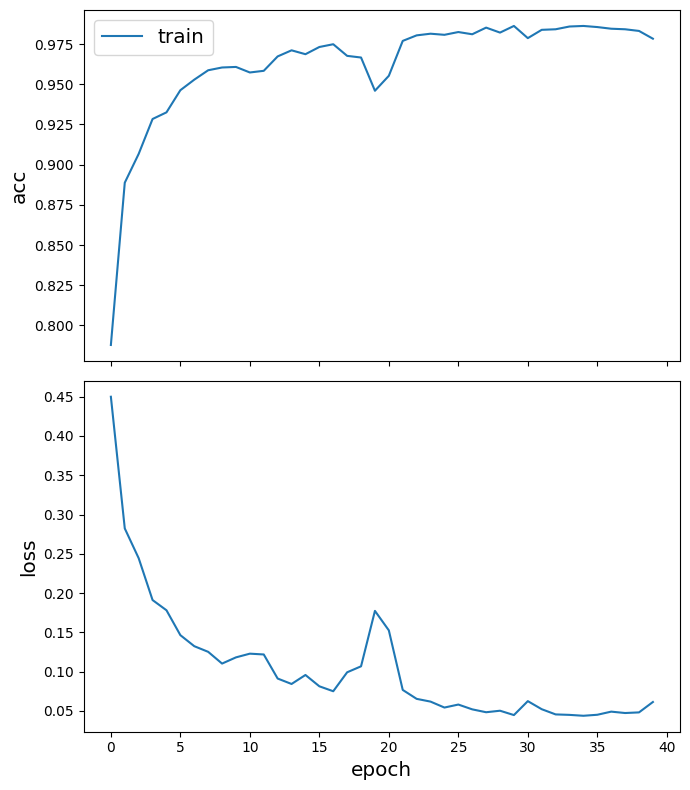

In [32]:
sg.utils.plot_history(history)

Finally, let us calculate the performance of the trained model on the test data.

180/180 [==============================] - 1s 4ms/step


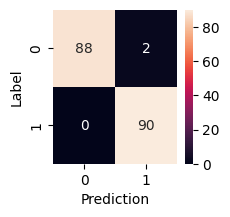

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
y_pred = model.predict(test_gen)
y_pred = y_pred.round() #输出是置信度，按四舍五入作为分类
y_true = list(test_graphs[1])
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(2, 2))
sns.heatmap(confusion_mtx,
            xticklabels=[0,1],
            yticklabels=[0,1],
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()